In [120]:
import pandas as pd

# Specify the file path
file_path = "new-thyroid.data"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_path, header=None)
display(df.head(5))

# Select desired columns
data = df.iloc[:, 1:6].values  # Assuming columns 1 to 5

print(data)

# Save column zero as true_labels
true = df.iloc[:, 0]
true_labels = pd.DataFrame()
true_labels["label"] = true
display(true_labels.head(5))

,0,1,2,3,4,5
0,1,107,10.1,2.2,0.9,2.7
1,1,113,9.9,3.1,2.0,5.9
2,1,127,12.9,2.4,1.4,0.6
3,1,109,5.3,1.6,1.4,1.5
4,1,105,7.3,1.5,1.5,-0.1


[[107.   10.1   2.2   0.9   2.7]
 [113.    9.9   3.1   2.    5.9]
 [127.   12.9   2.4   1.4   0.6]
 ...
 [103.    5.1   1.4   1.2   5. ]
 [ 97.    4.7   1.1   2.1  12.6]
 [102.    5.3   1.4   1.3   6.7]]


,label
0,1
1,1
2,1
3,1
4,1


In [121]:
print(len(data))

215


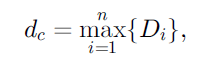

In [122]:
distances = []
from scipy.spatial.distance import euclidean
import numpy as np

print(data[0])
print(data[1])
my_distance = []
distances = []

for i in range(len(data)):
    min_distance = np.inf
    for j in range(len(data)):
        if i != j:
            distance = euclidean(data[i] , data[j])

            if distance < min_distance:
                min_distance = distance
    distances.append(min_distance)

# Calculate the maximum distance, dc
dc = max(distances)
print(dc)

[107.   10.1   2.2   0.9   2.7]
[113.    9.9   3.1   2.    5.9]
17.209299811439163


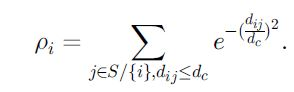

In [123]:

def calculate_density(dataset, dc):
    n = len(dataset)
    densities = []

    for i in range(n):
        sigma =0

        for j in range(n):
          dij = euclidean(dataset[i] , dataset[j])
          if i!=j and dij <= dc :


              sigma += math.exp(-((dij/dc)**2))


        densities.append(sigma)


    return densities






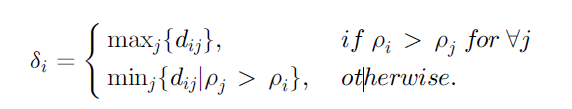

In [124]:
from tqdm import tqdm
def upward_distances(dataset, densities):
    n = len(dataset)
    distances = np.zeros(n)

    for i in tqdm(range(n)):
        if densities[i] == np.max(densities):
          distances[i] = np.max([euclidean(dataset[i], dataset[j]) for j in range(n) ])
        else :
          min_distance = np.inf
          for j in range(n):
            if (densities[j] > densities[i]) and (i != j):
                distance = euclidean(dataset[i], dataset[j])
                min_distance = min(min_distance, distance)
          distances[i] = min_distance

    return distances

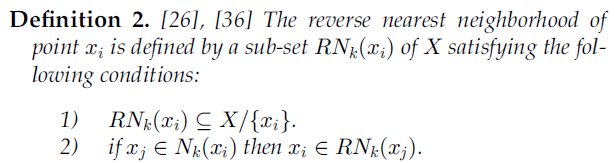

In [125]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def calculate_reverse_nearest_neighbors(data, k):
    n = len(data)
    RNN = []

    # Create k-NN model
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model with the data
    knn.fit(data, range(n))

    # Get the k nearest neighbors for each point
    _, indices = knn.kneighbors(data)

    # Store the reverse nearest neighbors
    for i in range(n):
        RNNi = [j for j in range(n) if i in indices[j] and j != i]
        #RNNi = [data[j] for j in indices[i] if j != i]
        RNN.append(RNNi)
    rnn_count = [len(RNNi) for RNNi in RNN]

    return rnn_count


 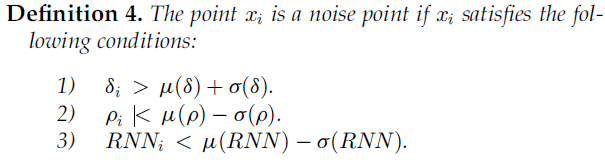

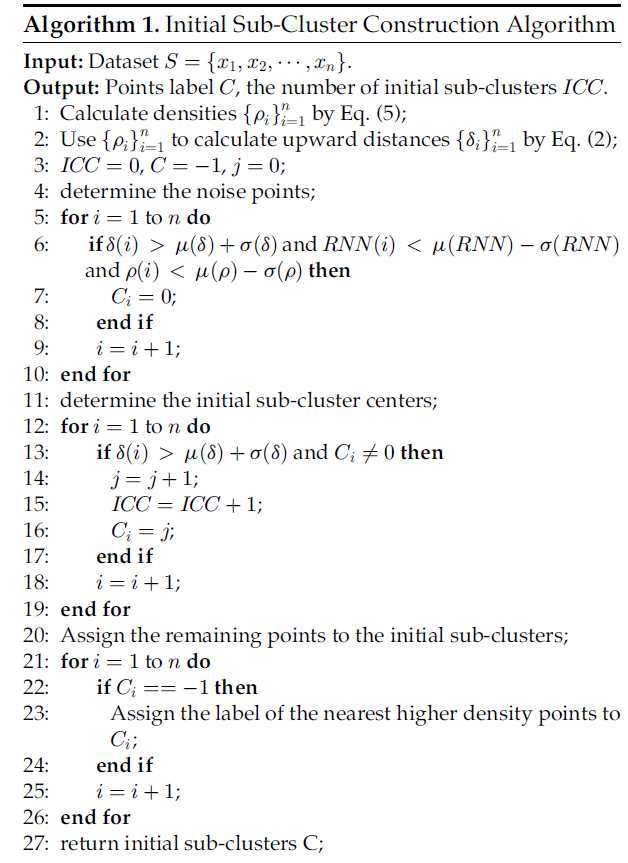

In [126]:
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

#def Algho1(data):
n = len(data)
C_values = -np.ones(n)  # ci = -1
ICC = 0
j = 0

densities = calculate_density(data, dc)  # 1

distances = upward_distances(data, densities)  # 2

RNN = calculate_reverse_nearest_neighbors(data, 4)  # 3

mean_density = np.mean(densities)
std_density = np.std(densities)

mean_upward = np.mean(distances)
std_upward = np.std(distances)

mean_RNN = np.mean(RNN)
std_RNN = np.std(RNN)
print(mean_RNN)
print(std_upward)

for i in tqdm(range(len(data))):  # determine noise
    data_i = data[i]
    density_i = densities[i]
    upward_i = distances[i]
    RNNi = RNN[i]

    if (density_i < mean_density - std_density) and (upward_i > mean_upward + std_upward) and (RNNi < mean_RNN - std_RNN):
        C_values[i] = 0
       # print("noise")

cluster_centers = []
for i in range(len(data)):  # determine subcluster centers

    data_i = data[i]
    density_i = densities[i]
    upward_i = distances[i]

    if upward_i > (mean_upward + std_upward) and C_values[i] != 0:

        j = j + 1
        ICC = ICC + 1
        C_values[i] = j
       # cluster_centers.append((data[i], C_values[i])) #for next algorythm
        cluster_centers.append( (i , ICC) )


distances = [] # store and sort distances for each point i asceding
for i in range(len(data)):
    distances_i = []
    for j in range(len(data)):
        if i != j:
            distance = euclidean(data[i], data[j])
            distances_i.append((j, distance))
    distances_i.sort(key=lambda x: x[1])  # Sort distances by ascending order
    distances.append(distances_i)

for i in range(len(data)):  # Assign remaining points to subclusters
    if C_values[i] == -1:
      for idx, distance in distances[i]:
        if C_values[idx] != -1 and C_values[idx] !=0 :
          if densities[idx] > densities[i]:
              C_values[i] = C_values[idx]
              break





100%|██████████| 215/215 [00:00<00:00, 718.72it/s] 


3.0
5.234783362656067


100%|██████████| 215/215 [00:00<00:00, 352118.45it/s]


In [129]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 1.0: 191 points
Cluster 2.0: 2 points
Cluster 3.0: 2 points
Cluster 7.0: 6 points
Cluster 8.0: 2 points
Cluster 4.0: 1 points
Cluster 9.0: 3 points
Cluster 5.0: 3 points
Cluster 6.0: 2 points
Cluster 0.0: 3 points


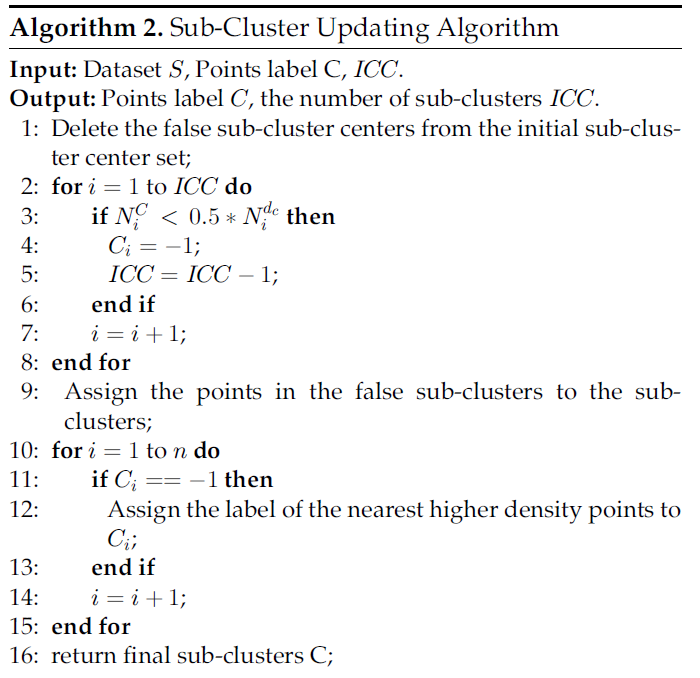

In [130]:
#### Delete the false sub-cluster centers from the initial sub-cluster center set
new_cluster_centers = []
for i in range(1 , ICC + 1 ) :

  points_in_dc_radius = 0

  points = [idx for idx, ci_value in enumerate(C_values) if ci_value == i]  # Find points belonging to the current subcluster
  new_cluster_centers.append(cluster_centers[i-1])
  #print(data[((cluster_centers[i-1])[0])])
  Nc = len(points)
  cluster_center = data[ (cluster_centers[i-1])[0] ]

  points_in_dc_radius = [idx for idx, point in enumerate(data) if euclidean(cluster_center, point) <= dc]  # Find points within radius dc from the center
  Ndc =  len(points_in_dc_radius)

  if Nc < 0.5 * Ndc :
    new_cluster_centers.remove(cluster_centers[i-1])

    for point_idx in points:
            C_values[point_idx] = -1
    ICC = ICC -1



#### Assign the points in the false sub-clusters to the subclusters

for i in range(len(data)):
    if C_values[i] == -1:
      for idx, distance in distances[i]:
        if C_values[idx] != -1 and C_values[idx] !=0 :
          if densities[idx] > densities[i]:
              C_values[i] = C_values[idx]
              break


[109.    9.7   1.4   1.1   2.1]
[67.  23.3  7.4  1.8 -0.6]
[68.  14.7  7.8  0.6 -0.2]
[119.    3.8   1.1  23.    5.7]
[118.    3.6   1.5  11.6  48.8]
[120.    1.9   0.7  18.5  24. ]
[131.    2.7   0.8   9.9   4.7]
[119.    5.1   1.1   7.   40.8]
[139.    4.2   0.7   4.3   6.3]


In [131]:
print(new_cluster_centers)


[(75, 1), (192, 5)]


In [132]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 1.0: 207 points
Cluster 5.0: 5 points
Cluster 0.0: 3 points


In [134]:
def find_min_distance_between_clusters(cluster1, cluster2):
    min_distance = np.inf
    for point1 in cluster1:

        for point2 in cluster2:
            distance = euclidean(data[point1], data[point2] )  # Calculate the distance between the two points
            if distance < min_distance:
                pi = point1
                pj = point2
                min_distance = distance
    return min_distance , pi , pj

In [135]:
def calculate_merging_radius( data , dc , C_values):
    noise_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == 0]  # Find the indices of noise points

    if len(noise_points) == 0:
        merging_radius = dc  # If no noise points, merging radius equals dc
    else:
        min_distances = []
        for i in range(len(data)):
            if i not in noise_points:
                min_distance = np.inf
                for j in range(len(data)):
                    if j != i and j not in noise_points:
                        distance = euclidean(data[i], data[j])  # Calculate the distance between points
                        if distance < min_distance:
                            min_distance = distance
                min_distances.append(min_distance)

        merging_radius = max(min_distances)  # Find the maximum minimum distance

    return merging_radius


In [136]:
def calculate_merging_radius1(data, dc, C_values):
    noise_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == 0]  # Find the indices of noise points

    if len(noise_points) == 0:
        merging_radius = dc  # If no noise points, merging radius equals dc
    else:
        min_distance = np.inf
        for i in range(len(data)):
            if i not in noise_points:
                for j in range(i + 1, len(data)):
                    if j not in noise_points:
                        distance = euclidean(data[i], data[j])  # Calculate the distance between points
                        if distance < min_distance:
                            min_distance = distance

        merging_radius = min_distance  # Use the minimum distance as the merging radius

    return merging_radius

In [137]:
def calculate_boundary_points(data, C_values, densities, ICC):
    boundary_points = []

    # Find the boundary points
    for ci in range(1, ICC + 1):
        label = (new_cluster_centers[ci-1])[1]
        cluster_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label]  # Find points belonging to the current subcluster
        average_density = np.mean([densities[idx] for idx in cluster_points])  # Calculate the average density of the subcluster
        boundary_points.extend([idx for idx in cluster_points if densities[idx] < average_density])  # Find the boundary points based on density

    return boundary_points

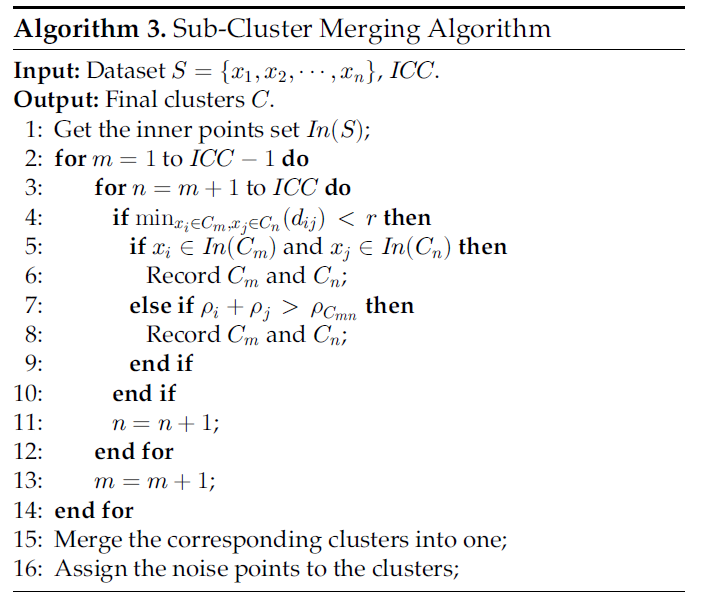

In [138]:
cluster_record = []
boundary_points = calculate_boundary_points(data, C_values, densities, ICC )
# Calculate inner points (subset In(X))
inner_points = [idx for idx in range(len(data)) if idx not in boundary_points]


for m in range ( 1 , ICC) :

  label_m = (new_cluster_centers[m-1])[1]

  n = m+1

  while n <= ICC :

    label_n = new_cluster_centers[n-1][1]

    cluster_m_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label_m]  # Find points in subcluster Cm
    cluster_n_points = [idx for idx, ci_value in enumerate(C_values) if ci_value == label_n]  # Find points in subcluster Cn

    density_Cm = densities[ ( new_cluster_centers[m - 1][0] ) ]
    density_Cn = densities[ ( new_cluster_centers[n - 1][0] ) ]
    density_Cmn = (density_Cm + density_Cn )  / 2

    min_dis , i_index , j_index = find_min_distance_between_clusters( cluster_m_points , cluster_n_points )
    r = calculate_merging_radius(data , dc , C_values)
    #print(min_dis)
  #  print(r)

    print(j_index)
    if min_dis < r :
      #for idx_m in cluster_m_points:
      #  for idx_n in cluster_n_points :
          if (i_index in inner_points) and (j_index in inner_points):
            print("salam1234")
            if (label_m , label_n) not in cluster_record :
               cluster_record.append((label_m, label_n))


          elif (densities[i_index] + densities[j_index]) > density_Cmn:
            print("salam")
            if (label_m , label_n) not in cluster_record :
               cluster_record.append((label_m, label_n))
    n += 1






186


In [139]:
print(cluster_record)

[]


In [140]:
# Merge the corresponding clusters into one
for cluster_m, cluster_n in cluster_record:
    for idx, ci_value in enumerate(C_values):
        if ci_value == cluster_n:
            C_values[idx] = cluster_m

In [141]:
# Assign the noise points to the nearest clusters
for idx, ci_value in enumerate(C_values):
    if ci_value == 0:
        noise_point = data[idx]
        min_distance = np.inf
        nearest_cluster = -1

        for data_idx, data_point in enumerate(data):
            if data_idx != idx and C_values[data_idx] != 0:
                distance = euclidean(noise_point, data_point)
                if distance < min_distance:
                    min_distance = distance
                    nearest_cluster = C_values[data_idx]

        C_values[idx] = nearest_cluster


In [142]:
cluster_counts = {}
for ci in C_values:
    if ci != -1:
        if ci in cluster_counts:
            cluster_counts[ci] += 1
        else:
            cluster_counts[ci] = 1

for ci, count in cluster_counts.items():
    print(f"Cluster {ci}: {count} points")

Cluster 1.0: 210 points
Cluster 5.0: 5 points


In [143]:
print(C_values)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 5. 1. 1. 1. 1. 1.
 5. 1. 1. 5. 1. 1. 5. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 5. 1. 1. 1. 1. 1.]


In [144]:
new_values = pd.DataFrame()
new_label = []
# Assign new labels to specific values in C_values
new_labels = []
for idx, ci_value in enumerate(C_values):

    if ci_value == 1:

        new_label = 1
        new_labels.append(new_label)

    elif ci_value == 5:
        new_label = 2
        new_labels.append(new_label)

    else :
        new_labels.append(ci_value)

print(len(new_labels))
df_new_labels = pd.DataFrame({'new_labels': new_labels})
display(df_new_labels)

215


,new_labels
0,1
1,1
2,1
3,1
4,1
...,...
210,1
211,1
212,1
213,1


In [145]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics.cluster import normalized_mutual_info_score

# Flatten the true_labels and new_labels
new_label = df_new_labels["new_labels"].values.flatten()
true_label = true_labels["label"].values.flatten()

# Calculate accuracy
accuracy = accuracy_score(true_label, new_label)

# Calculate recall
recall = recall_score(true_label, new_label, average='macro')

# Calculate normalized mutual information score
nmi = normalized_mutual_info_score(true_label, new_label)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Normalized Mutual Information Score:", nmi)

Accuracy: 0.6976744186046512
Recall: 0.3333333333333333
Normalized Mutual Information Score: 0.10211871680912103
